In [74]:
import time
import math
import pandas as pd
import numpy as np
import torch as T
import random
import matplotlib.pyplot as plt
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pandas.api.types import is_numeric_dtype
from collections import namedtuple, deque

In [75]:
class config():
    def __init__(self):
        self.device = T.device("cuda") if T.cuda.is_available() else T.device("cpu")
        self.bs = 256
        self.seq_len = 1
        self.epochs = 10
        self.cash = 25_000
        self.lr = 1e-3
        self.gamma = 0.99
        self.epsilon = 1.
        self.eps_dec = .9999
        self.eps_min = 1e-2
        self.mem_size = 1000
        self.replace_cnt = 1000
        
config = config()

# DDQN

In [76]:
class DeepQNetwork(nn.Module):
    def __init__(self, model, n_actions, n_cont, emb_dims, hidden_size, nlayers, name, chkpt_dir):
        # https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/
        super(DeepQNetwork, self).__init__()
        self.model = model
        self.emb_layers = nn.ModuleList([nn.Embedding(i,j) for i,j in emb_dims])
        
        self.n_embs = sum([j for _,j in emb_dims])
        self.n_cont = n_cont
        n_feats = self.n_cont + self.n_embs
        self.hidden_size = hidden_size
        self.nlayers = nlayers
        
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)
        
        if model=='lstm':
            self.lstm = nn.LSTM(n_feats, hidden_size, self.nlayers, batch_first=True)
            self.hn = T.zeros((self.nlayers,config.seq_len,self.hidden_size), device=config.device)
            self.cn = T.zeros((self.nlayers,config.seq_len,self.hidden_size), device=config.device)
        elif model=='gru':
            self.gru = nn.GRU(n_feats, hidden_size, self.nlayers, batch_first=True)
            self.hn = T.zeros((self.nlayers,config.seq_len,self.hidden_size), device=config.device)
            
        self.fc_1 = nn.Linear(hidden_size, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, n_actions)
        self.relu = nn.ReLU()
        
        self.optimizer = optim.Adam(self.parameters(), lr=config.lr)
        
        self.to(config.device)
            
    def forward(self, state):
        bs = state.size(0)
        cat_data = state[:,:15].long()
        cont_data = state[:,15:]

        emb = [emb_layer(cat_data[:,i]) for i,emb_layer in enumerate(self.emb_layers)]
        emb_ = T.cat(emb,1)
        
        input_ = T.cat([emb_, cont_data],1).float()
        input_ = input_.unsqueeze(0)
        if self.model=='lstm':
            output, (self.hn, self.cn) = self.lstm(input_, (self.hn.detach(),self.cn.detach())) # self.hn, self.cn
        elif self.model=='gru':
            output, self.hn = self.gru(input_, self.hn.detach()) # self.hn
        output = output.contiguous().view(bs,-1)
        out = self.relu(output)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc_2(out)
        out = self.relu(out)
        out = self.fc_3(out)
        return T.softmax(out,1)
    
    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

# Replay Buffer

In [77]:
Transitions = namedtuple('transitions',
                       ('states','actions','rewards','states_','dones'))

class ReplayBuffer():
    def __init__(self):
        self.memory = deque(maxlen=config.mem_size)

    def store_transition(self, states, actions, rewards, states_, dones):
        '''
        Using states_.size instead of states.size because a the shape mismatch when states_ is on the last step and thus isn't explicitily equal to the batch size
        This also just ignores the last bit of states since there's no other info to append with it.
        '''
        for idx in range(states_.size(0)):
            try:
                self.memory.append(Transitions(states[idx], actions[idx], rewards[idx], states_[idx], dones[idx]))
            except Exception:
                pass

    def sample_buffer(self):
        global s
        s = random.sample(self.memory,config.bs)

        states = s[0].states.unsqueeze(0)
        actions = s[0].actions.unsqueeze(0)
        rewards = s[0].rewards.unsqueeze(0)
        states_ = s[0].states_.unsqueeze(0)
        dones = s[0].dones.unsqueeze(0)
        
        for x in range(1,len(s)):
            states = T.cat((states,s[x].states.unsqueeze(0)),dim=0)
            actions = T.cat((actions,s[x].actions.unsqueeze(0)),dim=0)
            rewards = T.cat((rewards,s[x].rewards.unsqueeze(0)),dim=0)
            states_ = T.cat((states_,s[x].states_.unsqueeze(0)),dim=0)
            dones = T.cat((dones,s[x].dones.unsqueeze(0)),dim=0)
            
        return states, actions, rewards, states_, dones

    def __len__(self):
        return len(self.memory)

# Agent

In [78]:
# https://www.mlq.ai/deep-reinforcement-learning-pytorch-implementation/
class DDQNAgent(object):
    def __init__(self, model, n_actions, cons, cats, emb_dims, algo=None, env_name=None, chkpt_dir='tmp/dqn'):
        self.epsilon = config.epsilon
        self.n_actions = n_actions
        self.cols = cons.shape[0] + cats.shape[0]
        self.input_dims = (1, self.cols)
        self.algo = algo
        self.env_name = env_name
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0
        self.mse = nn.MSELoss()
        self.loss = 0

        self.memory = ReplayBuffer()

        self.q_eval = DeepQNetwork(model, self.n_actions, n_cont=cons.shape[0], emb_dims=emb_dims, hidden_size=200, nlayers=2, name=f'{self.env_name}_{self.algo}_q_eval', chkpt_dir=self.chkpt_dir)
        self.q_next = DeepQNetwork(model, self.n_actions, n_cont=cons.shape[0], emb_dims=emb_dims, hidden_size=200, nlayers=2, name=f'{self.env_name}_{self.algo}_q_next', chkpt_dir=self.chkpt_dir)

    def store_transition(self, states, actions, rewards, states_, dones):
         self.memory.store_transition(states, actions, rewards, states_, dones)
            
    def sample_memory(self):
        state,action,reward,state_,done = self.memory.sample_buffer()

        states  =  state.squeeze().to(config.device)
        states_ = state_.squeeze().to(config.device)
        actions = action.unsqueeze(-1).to(config.device)
        rewards = reward.unsqueeze(-1).to(config.device)
        dones   =   done.unsqueeze(-1).to(config.device)

        return states, actions, rewards, states_, dones
        
    def choose_action(self, observations):
        actionlist = [None] * observations.size(0)
        states = observations.to(config.device)
        actions = self.q_eval.forward(states)
        actions = T.argmax(actions, dim=1)
        for idx in range(actions.size(0)):
            if np.random.random_sample() > self.epsilon:
                action = actions[idx].item()
            else:
                action = np.random.choice(self.action_space)
            actionlist[idx] = action
        actions = T.tensor(actionlist)
        return actions

    def replace_target_network(self):
        if self.learn_step_counter % config.replace_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon * config.eps_dec if self.epsilon > config.eps_min else config.eps_min

    def learn(self):
        if len(self.memory) < config.bs:
            return

        self.replace_target_network()
        s,a,r,s_,d = self.sample_memory()
        
        a = a.long()        
        q = self.q_eval.forward(s).gather(-1,a)
        
        a_ = T.argmax(self.q_eval.forward(s_),1).unsqueeze(-1)
        
        q_ = self.q_next.forward(s_).gather(-1,a_.long())
        q_ = r + config.gamma * q_ * (1-d)
        
        loss = self.mse(q, q_)
        self.q_eval.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.q_eval.optimizer.step()
        self.loss = loss.item()
        self.learn_step_counter += 1

        self.decrement_epsilon()

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

# Environment

In [79]:
class MarketEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, nfeats):
        super(MarketEnv, self).__init__()
        self.n_actions = 3 # {Buy: 0, Sell: 1, Hold: 2}
        self.action_space = spaces.Discrete(self.n_actions)
        self.observation_space = spaces.Box(low=0, high=1, shape=(nfeats,config.bs))

        self.cash = config.cash
        self.shares_owned = 0
        self.reward = 0
        self.done = 0
        self.n_trades = 0
        self.close = None
        self.prev_close = 0.672762 # First close value (normalized)
        self.risum = 0
        self.rfsum = 0
        self.initial_bh = self.prev_close # initial buy and hold price
        
    def step(self, actions, states):
        num_shares = 10
        buy = False
        sel = False
        reward = [None] * actions.size(0)
        done = [None] * actions.size(0)
        trades = [None] * actions.size(0)
        self.acc_values = [None] * actions.size(0)
        closes = states[:,19]
        
        for idx,element in enumerate(zip(actions, closes)):
            action, self.close = element

            if action==0 and not buy: # Buy
                buy = True
                sel = False
                self.n_trades += 1
                self.cash -= self.close * num_shares # Cost basis
                self.shares_owned += num_shares
            elif action==1 and not sel: # Sell
                buy = False
                sel = True
                self.n_trades += 1
                self.cash += num_shares * self.close
                self.shares_owned -= num_shares
            elif action==2:
                buy = False
                sel = False

#             self.reward = self.reward_math(buy, sel)
            if self.acc_values[-1] < (self.cash + self.shares_owned * self.close):
                self.reward = -1
            elif self.acc_values[-1] > (self.cash + self.shares_owned * self.close):
                self.reward = 1
            else:
                self.reward = 0
            self.done = 1 if self.cash < 0 else 0 # Need enough cash to open a position
            self.acc_values[idx] = self.cash + self.shares_owned * self.close
            
            reward[idx] = self.reward
            done[idx] = self.done
            self.prev_close = self.close
        
        rewards = T.tensor(reward)
        dones = T.tensor(done)
        
        return [rewards, dones]

#     https://ai.stackexchange.com/questions/10082/suitable-reward-function-for-trading-buy-and-sell-orders/10912
    def reward_math(self, buy, sel):
        fees = 0.0025 # Fees associated with making a trade. Set to 0.25% per trade
        excess_trading_loss = math.log((1-fees)/(1+fees))
        log_close = math.log(self.close)
        log_prev_close = math.log(self.prev_close)
        self.risum += buy * (log_close - log_prev_close)
        self.rfsum += sel * 0.1 * self.prev_close / 525_600 # 10% * previous minute's closing price / minutes per year (i.e. Baseline growth per share)
        r = self.risum + self.rfsum
        rbh = self.close - self.initial_bh + excess_trading_loss
        return math.tanh(0.01*(r - rbh))

    def reset(self):
        self.cash = config.cash
        self.acc_value = config.cash
        self.n_trades = 0
        self.shares_owned = 0
        self.done = 0
        self.risum = 0
        self.rfsum = 0
        
        return T.zeros(config.bs,nfeats)
    
    def render(self, baseline, accv, loss=None):
        if type(loss)==dict:
            fig = plt.figure(figsize=(35,10))
            gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
            (ax1, ax2) = gs.subplots(sharex='col')
            for key in loss.keys():
                ax1.plot(np.linspace(0,len(accv[key]),len(loss[key])),loss[key], label=f'Epoch {key}')
                ax2.plot(np.linspace(0,len(accv[key]),len(accv[key])),accv[key], label=f'Epoch {key}')
            ax2.plot(np.linspace(0,len(baseline),len(baseline)),baseline, color='gray', label='Baseline');
            ax2.set_xlabel('Minutes')
            ax2.set_xlim(xmin=-3)
            fig.suptitle(f'Loss and Account Value over {key+1} epochs')
            ax1.set_ylabel('Loss')
            ax2.set_ylabel('Account Value')
            ax2.legend(bbox_to_anchor=(1.0, 2.03), loc='upper left')
            plt.show()
            
        else:
            fig = plt.figure(figsize=(35,10))
            plt.plot(np.linspace(0,len(accv['test']),len(accv['test'])), accv['test'], color='red', label='Test')
            plt.plot(np.linspace(0,len(baseline),len(baseline)), baseline, color='gray', label='Baseline');
            plt.title('Trained Models vs Baseline Buy and Hold')
            plt.xlabel('Minutes')
            plt.xlim(xmin=-3)
            plt.ylabel('Account Value')
            plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')
            plt.show()

# Preparing the data

In [80]:
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.shuffle = shuffle

        n_batches, remainder = divmod(self.dataset_len, config.bs)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = T.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+config.bs] for t in self.tensors)
        self.i += config.bs
        return batch[0]

    def __len__(self):
        return self.n_batches
    
    
def categorify(df1, cats):
    df1.loc[:,cats] = df1.loc[:,cats].astype('int')
    embs = {}
    for col in cats:
        embs[col] = df1.loc[:,col].unique().tolist()
        embs[col].sort()

    for key in embs:
        for idx,val in enumerate(embs[key]):
            df1.loc[:,key].replace(val,idx,inplace=True)
    df1.loc[:,cats] = df1.loc[:,cats].astype('category')
    return df1

def normalize(df1, conts):
    mean,std = None,None
    for col in conts:
        assert is_numeric_dtype(df1[col]), "Column is not numeric"
        mn,mx = df1[col].min(), df1[col].max()
        df1[col] = (df1[col] - mn)/(mx-mn) + 1e-9
    return df1

def test_train_split(df, split_idx):
    return df.iloc[:split_idx,:].copy(), df.iloc[split_idx:,:].copy()
        
def prep_data(df, split_idx):
    cont_feats = df.columns[15:]
    cat_feats = df.columns[:15]
    
    df = categorify(df, cat_feats)
    traindf, testdf = test_train_split(df,split_idx)
    cat_nuniq = [df.loc[:,x].nunique() for x in cat_feats]
    emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_nuniq]
    
    traindf = normalize(traindf, cont_feats)
    testdf = normalize(testdf, cont_feats)

    trainT = T.tensor(traindf.values)
    testT = T.tensor(testdf.values)
    traindl = FastTensorDataLoader(trainT)
    testdl = FastTensorDataLoader(testT)

    return traindl, testdl, (cont_feats, cat_feats), emb_dims

# Modeling

In [81]:
def train(baseline, traindl, env, agent):
    start = time.time()
    loss = {}
    account_value = {}
    space = 15
    acc_sum = 0
    max_acc = 0
    states_ = None
    for i in range(config.epochs):
        estart = time.time()
        loss[i] = []
        account_value[i] = []
        states = env.reset()
        if i==0:
            states_ = states
        for step,states in enumerate(traindl):
            actions = agent.choose_action(states)
            rewards, dones = env.step(actions, states)
            
            agent.store_transition(states, actions, rewards, states_, dones)
            agent.learn()
            states_ = states
            account_value[i] += env.acc_values
            loss[i].append(agent.loss)
        avg_acc_val = sum(account_value[i])/len(account_value[i])
        max_acc_val = max(account_value[i])
        emin,esec = divmod(time.time()-estart,60)
        t = f'{emin:02.0f}:{esec:02.0f}'
        print(f'Epoch: {i} | Acc value: ${account_value[i][-1]:,.2f} | Avg acc value: ${avg_acc_val:,.2f} | Max acc value: ${max_acc_val:,.2f} | Epsilon: {agent.epsilon:.5f} | Max Loss: {max(loss[i].5f)} | Elapsed: {t}')

    m, s = divmod(time.time()-start, 60)
    h, m = divmod(m, 60)
    t = f'{h:02.0f}:{m:02.0f}:{s:02.0f}'
    print(f'Total training time: {t:^10}\n\n')
    env.render(baseline, account_value, loss)
    
def test(baseline, testdl, env, agent):
    start = time.time()
    account_value = {'test':[]}
    space = 15
    acc_sum = 0
    max_acc = 0
    states = env.reset()
    
    for states in testdl:
        actions = agent.choose_action(states)
        rewards, dones = env.step(actions, states)
        account_value['test'] += env.acc_values

    avg_acc_val = sum(account_value['test'])/len(account_value['test'])
    max_acc_val = max(account_value['test'])
    print(f'Acc value: ${account_value["test"][-1]:,.2f} | Avg acc value: ${avg_acc_val:,.2f} | Max acc value: ${max_acc_val:,.2f}')

    env.render(baseline, account_value)

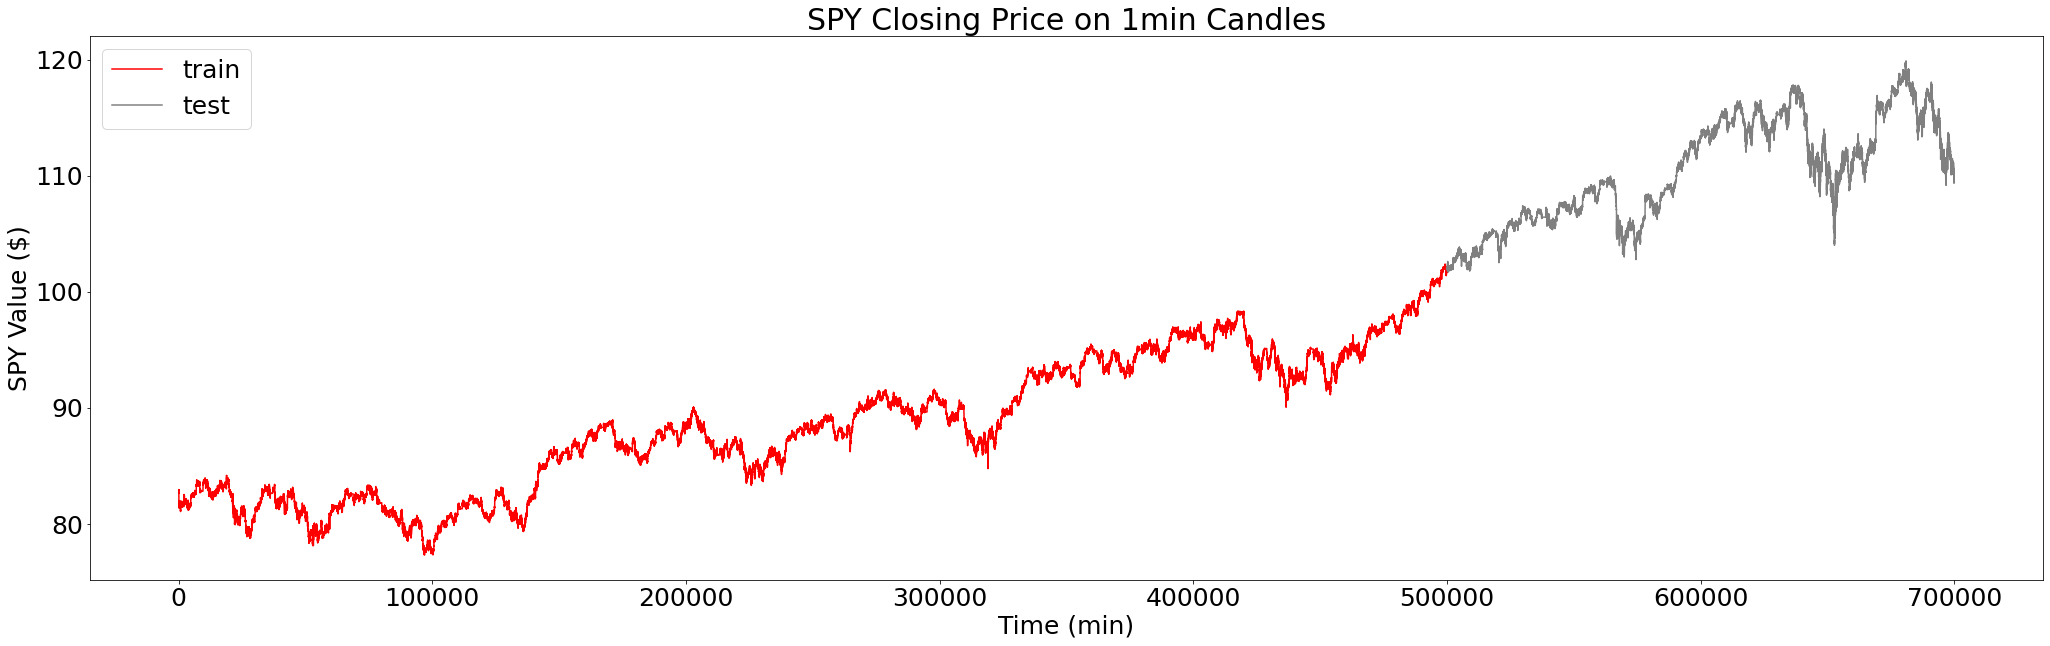

In [82]:
plt.rcParams.update({'font.size': 25})

traindf = pd.read_pickle('../input/d/filipinogambino/historicals/first_500000.pkl')
testdf = pd.read_pickle('../input/d/filipinogambino/historicals/test_set.pkl')
fig = plt.figure(figsize=(35,10))
plt.plot(traindf.index, traindf.close_spy, color='red', label='train');
plt.plot(testdf.index, testdf.close_spy, color='gray', label='test');
plt.title('SPY Closing Price on 1min Candles')
plt.xlabel('Time (min)')
plt.ylabel('SPY Value ($)')
plt.legend()
plt.show()

Epoch: 0 | Acc value: $23,988.64 | Avg acc value: $24,572.26 | Max acc value: $25,580.94 | Epsilon: 0.86372 | Max Loss: 0.02393350377678871 | Elapsed: 02:45
Epoch: 1 | Acc value: $52,254.24 | Avg acc value: $35,410.19 | Max acc value: $57,770.57 | Epsilon: 0.74601 | Max Loss: 0.03556620329618454 | Elapsed: 02:43
Epoch: 2 | Acc value: $-18,777.96 | Avg acc value: $8,025.70 | Max acc value: $39,117.26 | Epsilon: 0.64434 | Max Loss: 0.025534097105264664 | Elapsed: 02:43
Epoch: 3 | Acc value: $-28,359.90 | Avg acc value: $4,078.31 | Max acc value: $42,416.66 | Epsilon: 0.55653 | Max Loss: 0.0016662763664498925 | Elapsed: 02:42
Epoch: 4 | Acc value: $23,611.46 | Avg acc value: $24,805.29 | Max acc value: $26,665.23 | Epsilon: 0.48069 | Max Loss: 0.030657172203063965 | Elapsed: 02:42
Epoch: 5 | Acc value: $24,286.45 | Avg acc value: $24,729.83 | Max acc value: $25,288.26 | Epsilon: 0.41518 | Max Loss: 0.019676094874739647 | Elapsed: 02:43
Epoch: 6 | Acc value: $26,061.93 | Avg acc value: $25

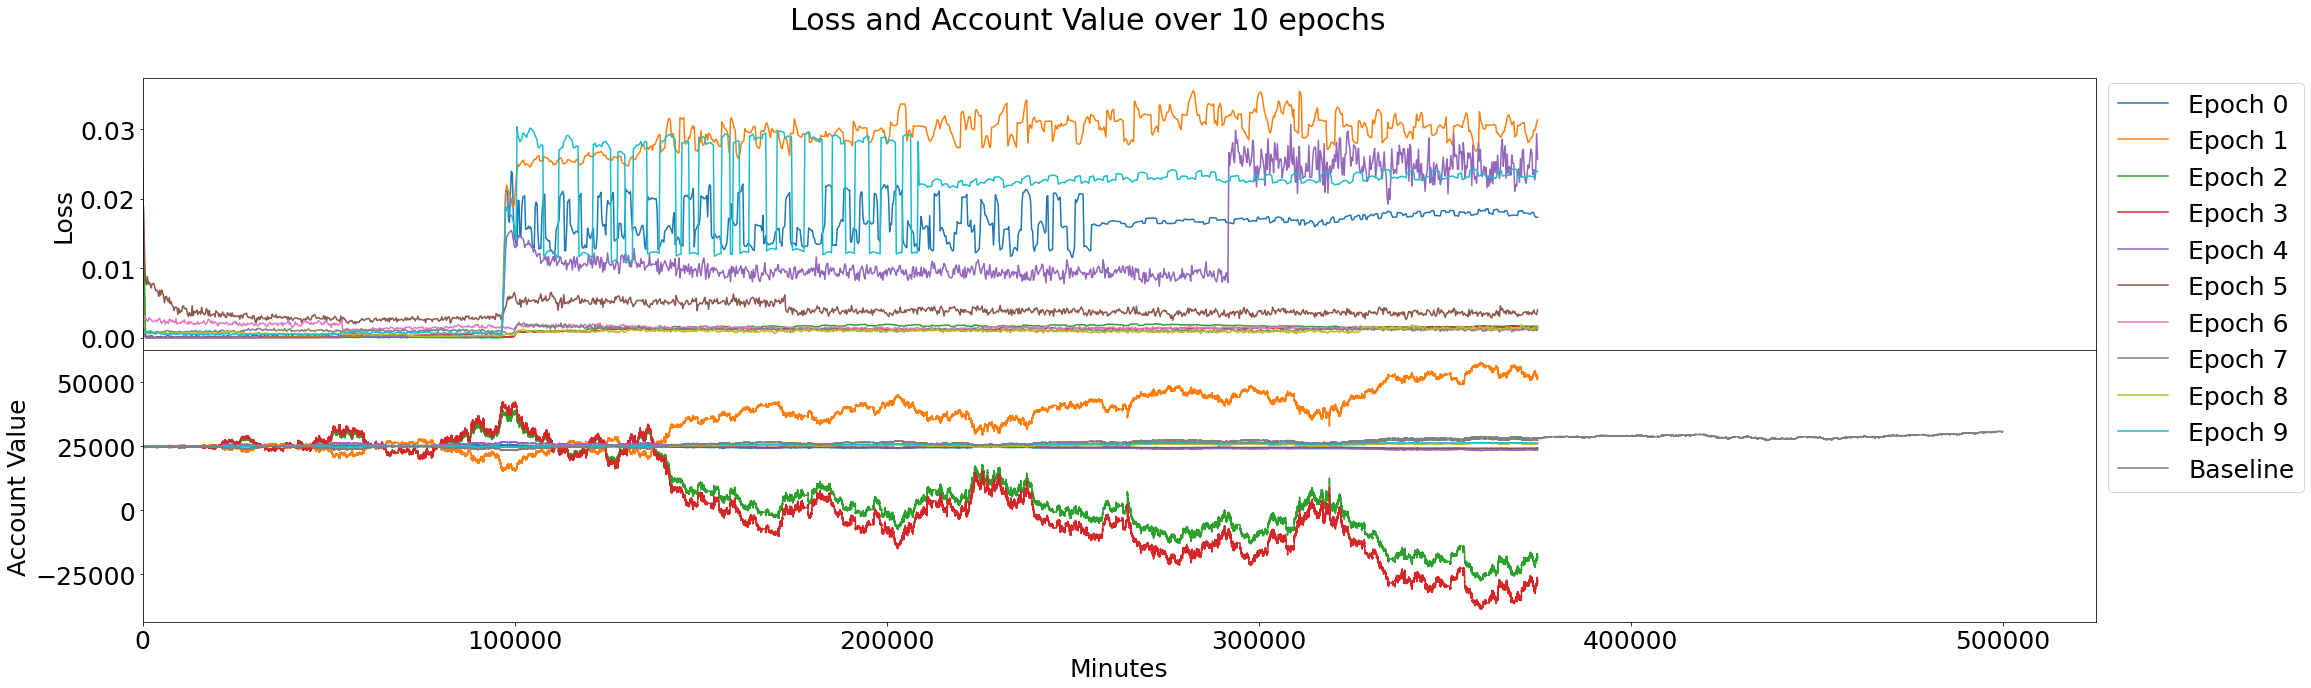

... saving checkpoint ...
... saving checkpoint ...
CPU times: user 27min 24s, sys: 4.75 s, total: 27min 29s
Wall time: 27min 34s


In [83]:
%%time

traindf = pd.read_pickle('../input/d/filipinogambino/historicals/first_500000.pkl').iloc[:,:-4] # OHCLV historical data
testdf = pd.read_pickle('../input/d/filipinogambino/historicals/test_set.pkl').iloc[:,:-4]
baseline_shares = config.cash / traindf.loc[0,'close_spy']
baseline_values = baseline_shares * traindf['close_spy']
df = pd.concat([traindf,testdf]).reset_index(drop=True)
traindl, testdl, feats, emb_dims = prep_data(df, split_idx=int(len(traindf)*.75))
nfeats = sum([x.shape[0] for x in feats])

env = MarketEnv(nfeats=nfeats)

load_checkpoint = False
if load_checkpoint:
    agent.load_models()
else:
    agent = DDQNAgent(model='gru', cons=feats[0], cats=feats[1], emb_dims=emb_dims, n_actions=env.action_space.n, chkpt_dir='./', algo='DDQNAgent', env_name='MarketEnv')

train(baseline_values, traindl, env, agent)
        
agent.save_models()

... loading checkpoint ...
... loading checkpoint ...
Acc value: $58,931.11 | Avg acc value: $54,192.24 | Max acc value: $124,977.16


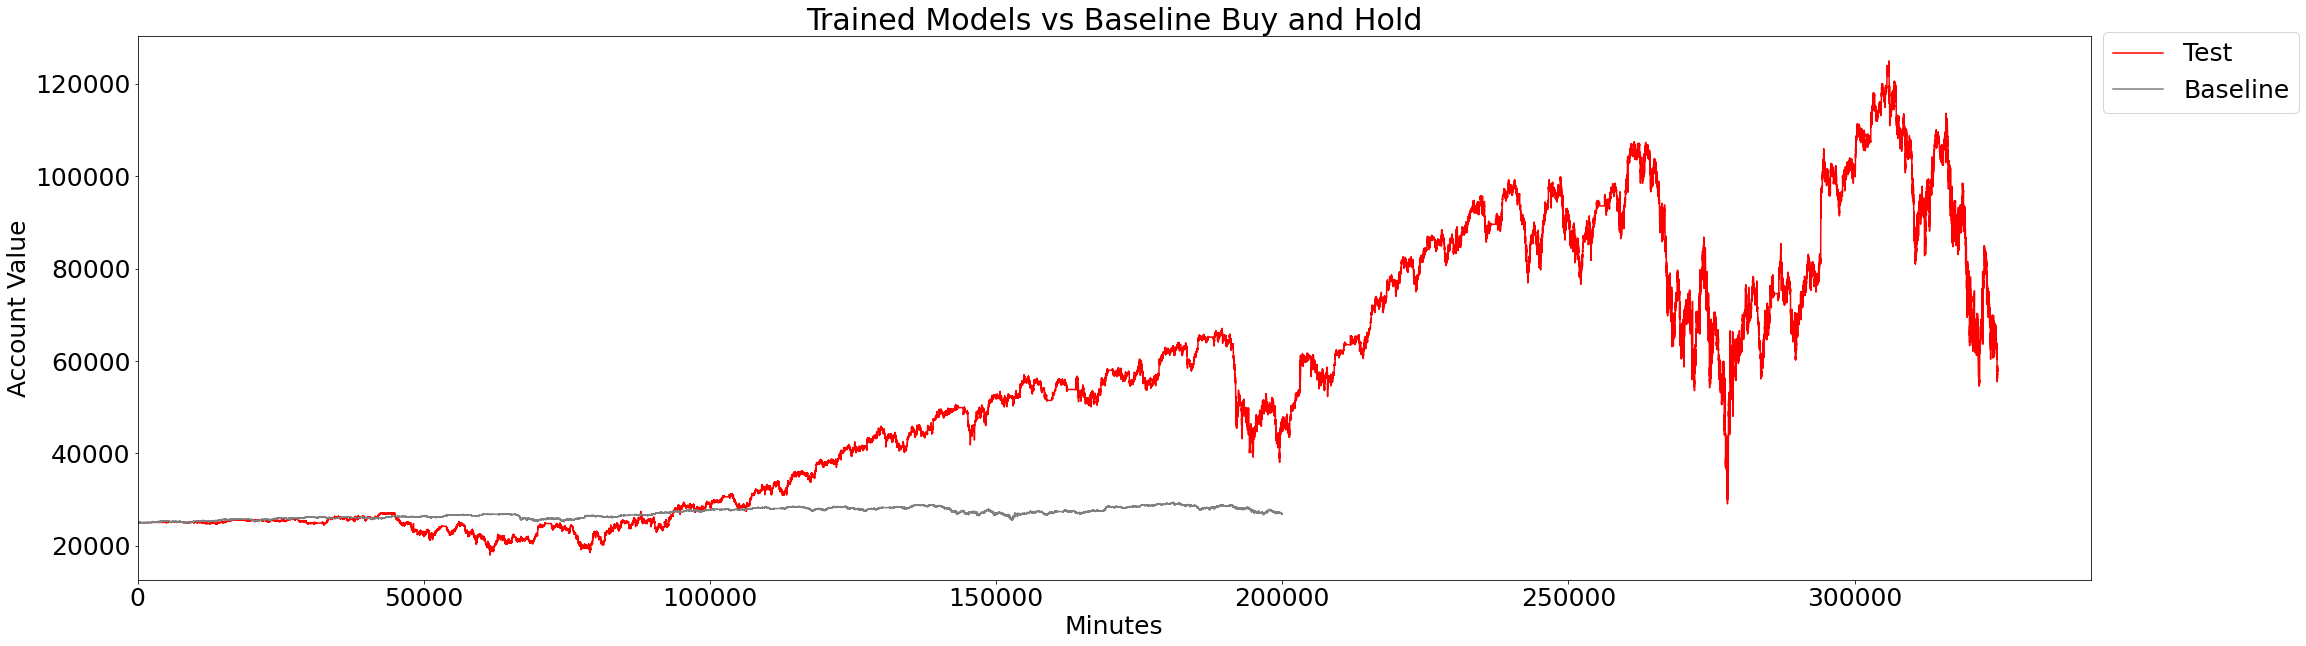

CPU times: user 1min, sys: 179 ms, total: 1min 1s
Wall time: 1min 1s


In [84]:
%%time

testdf = pd.read_pickle('../input/d/filipinogambino/historicals/test_set.pkl').iloc[:,:-4]
testdf = testdf.reset_index(drop=True)
baseline_shares = config.cash / testdf.loc[0,'close_spy']
baseline_values = baseline_shares * testdf['close_spy']

env = MarketEnv(nfeats=nfeats)
agent.load_models()

test(baseline_values, testdl, env, agent)